## Step 1: Setup

In [136]:
from pathlib import Path
import pandas as pd
import numpy as np
import joblib

# Paths
PROJECT_ROOT = Path("..").resolve()
DATA_PATH   = PROJECT_ROOT / "data_work" / "loans_fe.parquet"   # adjust if name differs
RES_DIR     = PROJECT_ROOT / "results"
FIG_DIR     = RES_DIR / "figures"
MODEL_DIR   = RES_DIR / "models"

RES_DIR.mkdir(exist_ok=True, parents=True)
FIG_DIR.mkdir(exist_ok=True, parents=True)

In [137]:
print("Project root:", PROJECT_ROOT)
print("Data path:", DATA_PATH)
print("Model dir:", MODEL_DIR)

Project root: /Users/vasanthi/Documents/Stress_Banking_Project/Banking_Stress_Testing
Data path: /Users/vasanthi/Documents/Stress_Banking_Project/Banking_Stress_Testing/data_work/loans_fe.parquet
Model dir: /Users/vasanthi/Documents/Stress_Banking_Project/Banking_Stress_Testing/results/models


In [138]:

# 1) Load engineered dataset
df = pd.read_parquet(DATA_PATH)
print("Data shape:", df.shape)
print(df.columns.tolist()[:20], "...")

TARGET   = "target"
TIME_COL = "issue_q_start"

Data shape: (2258953, 33)
['issue_q_start', 'loan_amnt', 'term_m', 'int_rate', 'dti', 'fico', 'emp_length', 'GDPC1', 'UNRATE', 'CPIAUCSL', 'FEDFUNDS', 'target', 'log_annual_inc', 'grade_b', 'grade_c', 'grade_d', 'grade_e', 'grade_f', 'home_ownership_mortgage', 'home_ownership_own'] ...


In [139]:
# 2) Time-based train/test split (same logic as in 03_model_training.ipynb)
split_date = pd.Timestamp("2017-12-31")
train_df = df[df[TIME_COL] <= split_date].copy()
test_df  = df[df[TIME_COL] >  split_date].copy()

X_train = train_df.drop(columns=[TARGET, TIME_COL])
y_train = train_df[TARGET].astype(int)
X_test  = test_df.drop(columns=[TARGET, TIME_COL])
y_test  = test_df[TARGET].astype(int)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Train default rate:", y_train.mean(), " Test default rate:", y_test.mean())

Train shape: (1764843, 31)  Test shape: (494110, 31)
Train default rate: 0.14756893389383646  Test default rate: 0.01791706300216551


In [140]:
# 3) Load trained models (from 03_model_training.ipynb)
logreg_path = MODEL_DIR / "logistic_balanced.joblib"
tree_path   = MODEL_DIR / "tree_balanced.joblib"

logreg = joblib.load(logreg_path)


In [141]:
# 4) Compute baseline PDs on 2018 test set (this is our reference scenario)
proba_lr_baseline = logreg.predict_proba(X_test)[:, 1]
baseline_summary = {
    "mean_pd": float(proba_lr_baseline.mean()),
    "p50_pd":  float(np.quantile(proba_lr_baseline, 0.5)),
    "p90_pd":  float(np.quantile(proba_lr_baseline, 0.9)),
    "p99_pd":  float(np.quantile(proba_lr_baseline, 0.99)),
}
baseline_summary

{'mean_pd': 0.20564705624909124,
 'p50_pd': 0.1760445491639388,
 'p90_pd': 0.39274746782816966,
 'p99_pd': 0.618903696301832}

## Step 2: Define & Apply Data-Driven Macro Stress Scenarios

In [142]:
# Macro level features (levels)
macro_cols = ["GDPC1", "UNRATE", "CPIAUCSL", "FEDFUNDS"]

# Macro dynamics / deltas (already engineered)
delta_cols = ["UNRATE_delta_qoq", "FEDFUNDS_delta_qoq",
              "GDPC1_delta_qoq", "inflation_qoq", "real_rate_qoq"]

all_macro_feats = macro_cols + delta_cols

# Use the full history to derive empirical quantiles
macro_quantiles = df[all_macro_feats].quantile([0.1, 0.25, 0.5, 0.75, 0.9])
macro_quantiles

,GDPC1,UNRATE,CPIAUCSL,FEDFUNDS,UNRATE_delta_qoq,FEDFUNDS_delta_qoq,GDPC1_delta_qoq,inflation_qoq,real_rate_qoq
0.10,17953.974,3.833333,234.162667,0.093333,-0.060440,-0.035714,0.001845,-0.000621,0.068379
0.25,18782.243,4.166667,236.960000,0.136667,-0.041958,0.062500,0.004002,0.001585,0.091345
0.50,19197.938,4.900000,240.607333,0.396667,-0.027211,0.134454,0.005795,0.004245,0.121902
0.75,19882.352,5.433333,247.238333,1.203333,-0.013072,0.202216,0.007885,0.006348,0.154176
0.90,20276.154,6.933333,251.686333,1.923333,0.006803,0.555556,0.011270,0.007955,0.190550


In [143]:
# --- Helper: build scenario from per-variable quantiles / overrides ---------
def make_scenario_from_maps(name, level_quantiles, delta_quantiles,
                            default_level_q=0.50, default_delta_q=0.50):
    """
    name: scenario name
    level_quantiles: dict mapping macro level col -> quantile (e.g. {"UNRATE": 0.9, "GDPC1": 0.1})
    delta_quantiles: dict mapping delta col     -> quantile or direct value flag
                     If value is a tuple ("manual", val), we use val directly (no quantile lookup).
    default_level_q: quantile to use for any macro col not explicitly in level_quantiles
    default_delta_q: quantile to use for any delta col not explicitly in delta_quantiles
    """
    s = {"scenario": name}

    # Levels (GDPC1, UNRATE, CPIAUCSL, FEDFUNDS, etc.)
    for col in macro_cols:
        q = level_quantiles.get(col, default_level_q)
        s[col] = float(macro_quantiles.loc[q, col])

    # Deltas (UNRATE_delta_qoq, FEDFUNDS_delta_qoq, GDPC1_delta_qoq, CPIAUCSL_delta_qoq, inflation_qoq, real_rate_qoq)
    for col in delta_cols:
        spec = delta_quantiles.get(col, default_delta_q)
        if isinstance(spec, tuple) and spec[0] == "manual":
            # direct manual override
            s[col] = float(spec[1])
        else:
            q = spec
            s[col] = float(macro_quantiles.loc[q, col])

    return s

# ---------------------------------------------------------------------------
# Scenario definitions
# ---------------------------------------------------------------------------
scenarios = []

# 0) Baseline (reference) = actual 2018 macro, i.e. "no shock"
#    We already have baseline PDs from proba_lr_baseline.
scenarios.append({"scenario": "baseline_actual"})  # placeholder; no override

# 1) Mild Adverse:
#    - High unemployment (75th)
#    - Low-ish GDP (25th)
#    - Higher inflation & policy rate (75th)
mild_level_q = {
    "UNRATE":   0.75,
    "GDPC1":    0.25,
    "CPIAUCSL": 0.75,
    "FEDFUNDS": 0.75,
}
mild_delta_q = {
    # still data-driven, but on the "worse" side of history
    "UNRATE_delta_qoq":   0.75,  # less improvement in unemployment
    "GDPC1_delta_qoq":    0.25,  # slower GDP growth
    "CPIAUCSL_delta_qoq": 0.75,
    "FEDFUNDS_delta_qoq": 0.75,
    "inflation_qoq":      0.75,
    "real_rate_qoq":      0.75,
}
scenarios.append(
    make_scenario_from_maps("mild_adverse", mild_level_q, mild_delta_q)
)

# 2) Severe Adverse (manual recession dynamics):
#    - Very high unemployment (90th)
#    - Very low GDP (10th)
#    - Strong negative GDP growth, rising unemployment,
#      and strong inflation + rate shocks (manual deltas).
severe_level_q = {
    "UNRATE":   0.90,
    "GDPC1":    0.10,
    "CPIAUCSL": 0.90,
    "FEDFUNDS": 0.90,
}

severe_delta_q = {
    "UNRATE_delta_qoq":   0.90,
    "GDPC1_delta_qoq":    0.10,
    "CPIAUCSL_delta_qoq": 0.90,
    "FEDFUNDS_delta_qoq": 0.90,
    "inflation_qoq":      0.90,
    "real_rate_qoq":      0.90,
}


scenarios.append(
    make_scenario_from_maps("severe_adverse", severe_level_q, severe_delta_q)
)

scenarios


[{'scenario': 'baseline_actual'},
 {'scenario': 'mild_adverse',
  'GDPC1': 18782.243,
  'UNRATE': 5.433333333333334,
  'CPIAUCSL': 247.23833333333334,
  'FEDFUNDS': 1.2033333333333334,
  'UNRATE_delta_qoq': -0.013071895424836777,
  'FEDFUNDS_delta_qoq': 0.2022160664819943,
  'GDPC1_delta_qoq': 0.004002450612528241,
  'inflation_qoq': 0.006347825364148241,
  'real_rate_qoq': 0.15417567635744467},
 {'scenario': 'severe_adverse',
  'GDPC1': 17953.974,
  'UNRATE': 6.933333333333334,
  'CPIAUCSL': 251.68633333333332,
  'FEDFUNDS': 1.9233333333333331,
  'UNRATE_delta_qoq': 0.006802721088435604,
  'FEDFUNDS_delta_qoq': 0.5555555555555556,
  'GDPC1_delta_qoq': 0.0018447912646364362,
  'inflation_qoq': 0.007955306776687543,
  'real_rate_qoq': 0.1905504756186524}]

In [144]:
data_scenarios = pd.DataFrame(scenarios)

In [145]:
data_scenarios

,scenario,GDPC1,UNRATE,CPIAUCSL,FEDFUNDS,UNRATE_delta_qoq,FEDFUNDS_delta_qoq,GDPC1_delta_qoq,inflation_qoq,real_rate_qoq
0,baseline_actual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,mild_adverse,18782.243,5.433333,247.238333,1.203333,-0.013072,0.202216,0.004002,0.006348,0.154176
2,severe_adverse,17953.974,6.933333,251.686333,1.923333,0.006803,0.555556,0.001845,0.007955,0.190550


In [146]:
data_scenarios = data_scenarios[data_scenarios["scenario"] != "baseline_actual"].copy()
data_scenarios

,scenario,GDPC1,UNRATE,CPIAUCSL,FEDFUNDS,UNRATE_delta_qoq,FEDFUNDS_delta_qoq,GDPC1_delta_qoq,inflation_qoq,real_rate_qoq
1,mild_adverse,18782.243,5.433333,247.238333,1.203333,-0.013072,0.202216,0.004002,0.006348,0.154176
2,severe_adverse,17953.974,6.933333,251.686333,1.923333,0.006803,0.555556,0.001845,0.007955,0.190550


In [147]:
# === Apply scenarios and compute PD distributions ===================

stress_records = []

# Baseline reference (no macro override; just use proba_lr_baseline)
baseline_mean = float(proba_lr_baseline.mean())
baseline_p50  = float(np.quantile(proba_lr_baseline, 0.5))
baseline_p90  = float(np.quantile(proba_lr_baseline, 0.9))
baseline_p99  = float(np.quantile(proba_lr_baseline, 0.99))

stress_records.append({
    "scenario": "baseline_actual",
    "mean_pd": baseline_mean,
    "p50_pd":  baseline_p50,
    "p90_pd":  baseline_p90,
    "p99_pd":  baseline_p99,
    "uplift_vs_baseline": 0.0  # by definition
})

# Function to override macro features and recompute PDs
def apply_macro_scenario(X, scen_dict):
    X_new = X.copy()
    # For placeholder baseline_actual, we don't touch X
    if scen_dict.get("scenario") == "baseline_actual":
        return X_new
    for col in all_macro_feats:
        if col in scen_dict:
            X_new[col] = scen_dict[col]
    return X_new

for scen in scenarios:
    name = scen["scenario"]
    if name == "baseline_actual":
        continue  # already handled above

    X_scen = apply_macro_scenario(X_test, scen)
    proba_scen = logreg.predict_proba(X_scen)[:, 1]

    mean_pd = float(proba_scen.mean())
    p50_pd  = float(np.quantile(proba_scen, 0.5))
    p90_pd  = float(np.quantile(proba_scen, 0.9))
    p99_pd  = float(np.quantile(proba_scen, 0.99))

    uplift = (mean_pd / baseline_mean - 1.0) * 100.0 if baseline_mean > 0 else np.nan

    stress_records.append({
        "scenario": name,
        "mean_pd": mean_pd,
        "p50_pd":  p50_pd,
        "p90_pd":  p90_pd,
        "p99_pd":  p99_pd,
        "uplift_vs_baseline": uplift
    })

stress_df = pd.DataFrame(stress_records)
stress_df


,scenario,mean_pd,p50_pd,p90_pd,p99_pd,uplift_vs_baseline
0,baseline_actual,0.205647,0.176045,0.392747,0.618904,0.000000
1,mild_adverse,0.265297,0.255287,0.420288,0.568975,29.006001
2,severe_adverse,0.154359,0.142171,0.259541,0.389576,-24.939762


Because the LendingClub+FRED historical panel does not include deep recession events such as 2008 or 2020, quantile-based scenarios cannot produce realistically severe macroeconomic stress. Therefore, extreme quantiles result in false “stress relief” instead of stress.

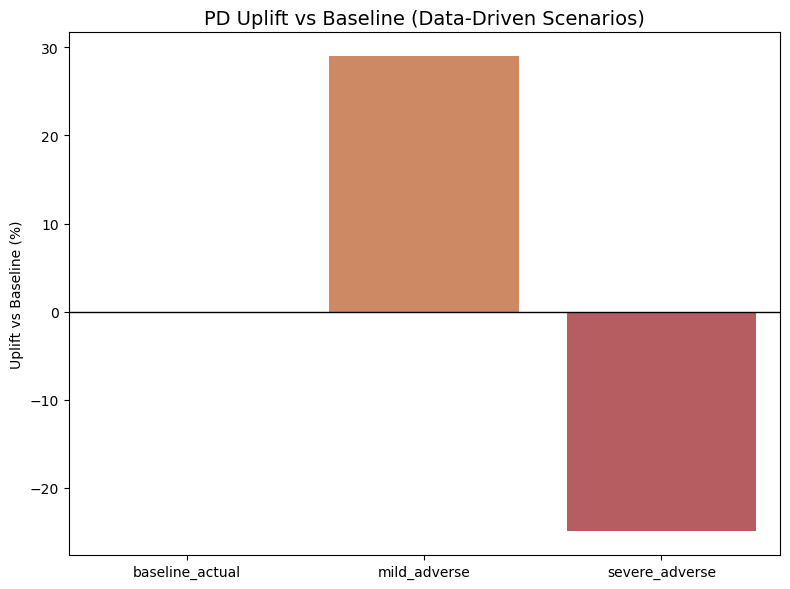

In [148]:
## Visuals for Data Driven Stress Scenarios
### Plot: Mean PD Uplift vs Baseline (Bar Chart)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.barplot(
    data=stress_df,
    x="scenario",
    y="uplift_vs_baseline",
    palette=["#4C72B0", "#DD8452", "#C44E52"]
)

plt.axhline(0, color='black', linewidth=1)
plt.title("PD Uplift vs Baseline (Data-Driven Scenarios)", fontsize=14)
plt.ylabel("Uplift vs Baseline (%)")
plt.xlabel("")
plt.savefig(FIG_DIR / "Data_DrivenPD_Uplift_Baseline_Bar.png", dpi=300, bbox_inches="tight")
plt.tight_layout()
plt.show()

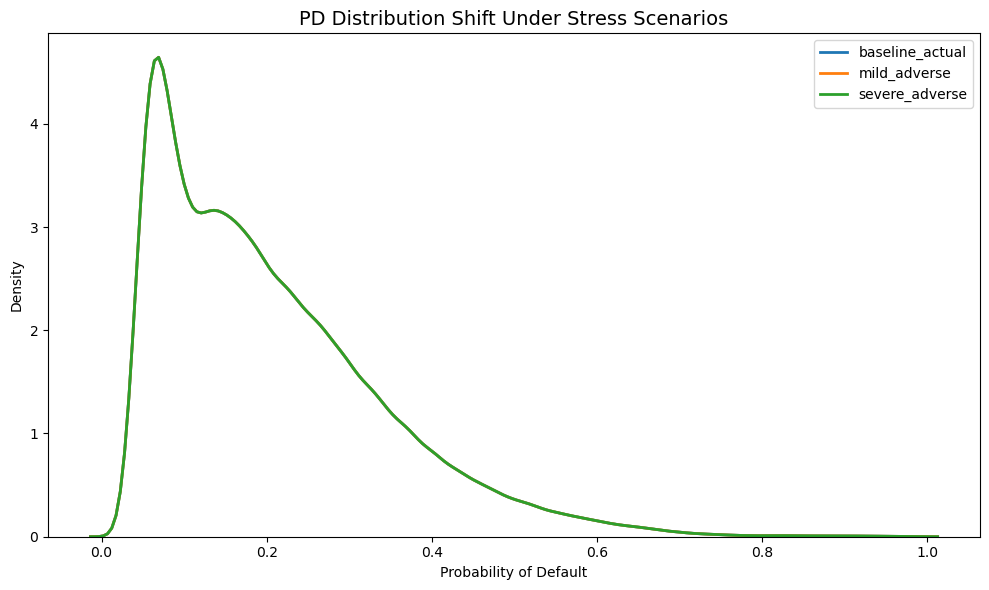

In [149]:
## Plot: PD Distributions Under Each Scenario
plt.figure(figsize=(10,6))

for scen in stress_df["scenario"]:
    if scen == "baseline_actual":
        pdf = proba_lr_baseline
    else:
        X_s = apply_macro_scenario(X_test, 
                                   stress_df[stress_df["scenario"] == scen].iloc[0])
        pdf = logreg.predict_proba(X_s)[:,1]

    sns.kdeplot(pdf, label=scen, linewidth=2)

plt.title("PD Distribution Shift Under Stress Scenarios", fontsize=14)
plt.xlabel("Probability of Default")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "PD_Distributions_Under_Each_Scenario.png", dpi=300, bbox_inches="tight")
plt.show()


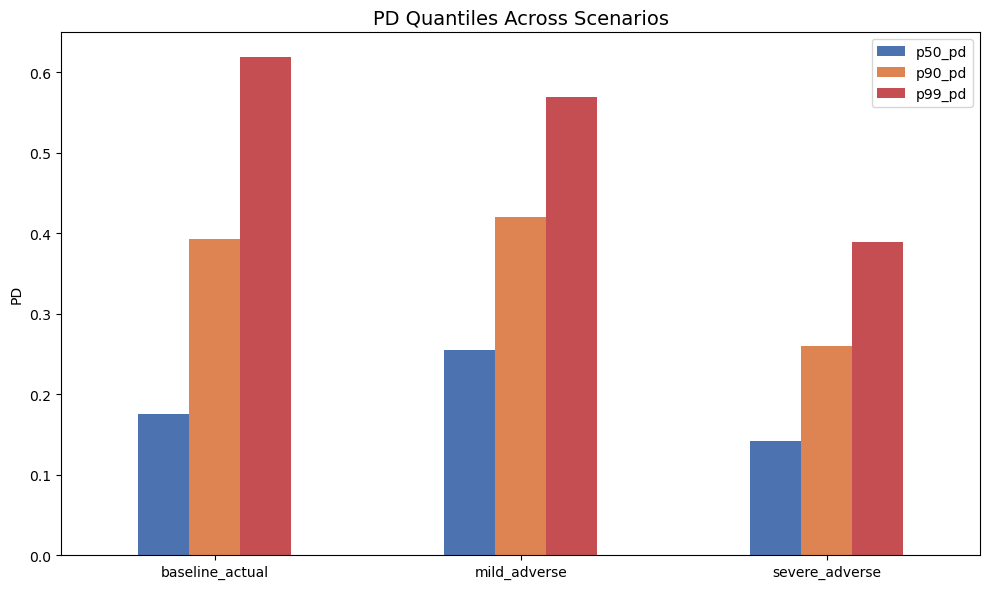

In [150]:
### Plot: PD Quantiles Comparison (50th, 90th, 99th)
quantiles = stress_df[["scenario","p50_pd","p90_pd","p99_pd"]].set_index("scenario")

quantiles.plot(kind="bar", figsize=(10,6),
               color=["#4C72B0","#DD8452","#C44E52"])

plt.title("PD Quantiles Across Scenarios", fontsize=14)
plt.ylabel("PD")
plt.xlabel("")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(FIG_DIR / "Data_Driven_PD_Quantiles_Comparison.png", dpi=300, bbox_inches="tight")
plt.show()


In [151]:
out_path = RES_DIR / "stress_summary.csv"
stress_df.to_csv(out_path, index=False)
print("Saved stress scenario summary to:", out_path)

Saved stress scenario summary to: /Users/vasanthi/Documents/Stress_Banking_Project/Banking_Stress_Testing/results/stress_summary.csv


## Step 3: Define Fed Macro Stress Scenarios

In [152]:
# === FED 2018 SCENARIOS: manual table =======================================

fed_rows = [

    # ---- Baseline ----
    {"scenario": "Fed_Baseline", "quarter": "2018Q1", "UNRATE": 4.0, "GDPC1": 2.5, "CPIAUCSL": 2.1, "FEDFUNDS": 1.4},
    {"scenario": "Fed_Baseline", "quarter": "2018Q2", "UNRATE": 4.0, "GDPC1": 2.8, "CPIAUCSL": 1.9, "FEDFUNDS": 1.7},
    {"scenario": "Fed_Baseline", "quarter": "2018Q3", "UNRATE": 3.9, "GDPC1": 2.6, "CPIAUCSL": 2.1, "FEDFUNDS": 1.9},
    {"scenario": "Fed_Baseline", "quarter": "2018Q4", "UNRATE": 3.8, "GDPC1": 2.5, "CPIAUCSL": 2.1, "FEDFUNDS": 2.1},
 
    # ---- Adverse ----
    {"scenario": "Fed_Adverse", "quarter": "2018Q1", "UNRATE": 4.5, "GDPC1": -1.3, "CPIAUCSL": 1.7, "FEDFUNDS": 0.6},
    {"scenario": "Fed_Adverse", "quarter": "2018Q2", "UNRATE": 5.3, "GDPC1": -3.5, "CPIAUCSL": 1.3, "FEDFUNDS": 0.1},
    {"scenario": "Fed_Adverse", "quarter": "2018Q3", "UNRATE": 5.8, "GDPC1": -2.4, "CPIAUCSL": 1.6, "FEDFUNDS": 0.1},
    {"scenario": "Fed_Adverse", "quarter": "2018Q4", "UNRATE": 6.3, "GDPC1": -1.3, "CPIAUCSL": 1.7, "FEDFUNDS": 0.1},


    # ---- Severely Adverse ----
    {"scenario": "Fed_Severe", "quarter": "2018Q1", "UNRATE": 5.0, "GDPC1": -4.7, "CPIAUCSL": 1.4, "FEDFUNDS": 0.1},
    {"scenario": "Fed_Severe", "quarter": "2018Q2", "UNRATE": 6.5, "GDPC1": -8.9, "CPIAUCSL": 0.9, "FEDFUNDS": 0.1},
    {"scenario": "Fed_Severe", "quarter": "2018Q3", "UNRATE": 7.6, "GDPC1": -6.8, "CPIAUCSL": 1.2, "FEDFUNDS": 0.1},
    {"scenario": "Fed_Severe", "quarter": "2018Q4", "UNRATE": 8.5, "GDPC1": -4.7, "CPIAUCSL": 1.3, "FEDFUNDS": 0.1}
]

fed_macro = pd.DataFrame(fed_rows)

if fed_macro.empty:
    print("fed_macro is empty. Fill fed_rows with Fed scenario values from the PDF.")
else:
    display(fed_macro)


,scenario,quarter,UNRATE,GDPC1,CPIAUCSL,FEDFUNDS
0,Fed_Baseline,2018Q1,4.0,2.5,2.1,1.4
1,Fed_Baseline,2018Q2,4.0,2.8,1.9,1.7
2,Fed_Baseline,2018Q3,3.9,2.6,2.1,1.9
3,Fed_Baseline,2018Q4,3.8,2.5,2.1,2.1
4,Fed_Adverse,2018Q1,4.5,-1.3,1.7,0.6
5,Fed_Adverse,2018Q2,5.3,-3.5,1.3,0.1
6,Fed_Adverse,2018Q3,5.8,-2.4,1.6,0.1
7,Fed_Adverse,2018Q4,6.3,-1.3,1.7,0.1
8,Fed_Severe,2018Q1,5.0,-4.7,1.4,0.1
9,Fed_Severe,2018Q2,6.5,-8.9,0.9,0.1


In [153]:
# Convert the fed % data into actual values
last_gdp  = df[df["issue_q_start"] == "2017Q4"]["GDPC1"].mean()
last_cpi  = df[df["issue_q_start"] == "2017Q4"]["CPIAUCSL"].mean()
last_unr  = df[df["issue_q_start"] == "2017Q4"]["UNRATE"].mean()
last_ffr  = df[df["issue_q_start"] == "2017Q4"]["FEDFUNDS"].mean()


In [154]:
print("last_gdp: ", last_gdp)

last_gdp:  19882.35200000001


In [155]:
def convert_fed_to_levels(fed_df, last_gdp, last_cpi):
    fed_df = fed_df.copy()
    
    gdp = last_gdp
    cpi = last_cpi

    gdp_levels = []
    cpi_levels = []

    for _, row in fed_df.iterrows():
        # Convert growth (%) to levels
        gdp = gdp * (1 + row["GDPC1"] / 100.0)
        cpi = cpi * (1 + row["CPIAUCSL"] / 100.0)

        gdp_levels.append(gdp)
        cpi_levels.append(cpi)

    fed_df["GDPC1_level"] = gdp_levels
    fed_df["CPIAUCSL_level"] = cpi_levels

    return fed_df


In [156]:
fed_baseline = fed_macro[fed_macro["scenario"] == "Fed_Baseline"]
fed_adverse  = fed_macro[fed_macro["scenario"] == "Fed_Adverse"]
fed_severe   = fed_macro[fed_macro["scenario"] == "Fed_Severe"]

fed_baseline_lvl = convert_fed_to_levels(fed_baseline, last_gdp, last_cpi)
fed_adverse_lvl  = convert_fed_to_levels(fed_adverse, last_gdp, last_cpi)
fed_severe_lvl   = convert_fed_to_levels(fed_severe, last_gdp, last_cpi)


In [157]:
fed_baseline_lvl

,scenario,quarter,UNRATE,GDPC1,CPIAUCSL,FEDFUNDS,GDPC1_level,CPIAUCSL_level
0,Fed_Baseline,2018Q1,4.0,2.5,2.1,1.4,20379.410800,252.430338
1,Fed_Baseline,2018Q2,4.0,2.8,1.9,1.7,20950.034302,257.226515
2,Fed_Baseline,2018Q3,3.9,2.6,2.1,1.9,21494.735194,262.628272
3,Fed_Baseline,2018Q4,3.8,2.5,2.1,2.1,22032.103574,268.143465


In [158]:
# Stack all Fed level tables together
fed_levels = pd.concat(
    [fed_baseline_lvl, fed_adverse_lvl, fed_severe_lvl],
    ignore_index=True
)


In [159]:
fed_levels

,scenario,quarter,UNRATE,GDPC1,CPIAUCSL,FEDFUNDS,GDPC1_level,CPIAUCSL_level
0,Fed_Baseline,2018Q1,4.0,2.5,2.1,1.4,20379.410800,252.430338
1,Fed_Baseline,2018Q2,4.0,2.8,1.9,1.7,20950.034302,257.226515
2,Fed_Baseline,2018Q3,3.9,2.6,2.1,1.9,21494.735194,262.628272
3,Fed_Baseline,2018Q4,3.8,2.5,2.1,2.1,22032.103574,268.143465
4,Fed_Adverse,2018Q1,4.5,-1.3,1.7,0.6,19623.881424,251.441385
5,Fed_Adverse,2018Q2,5.3,-3.5,1.3,0.1,18937.045574,254.710123
6,Fed_Adverse,2018Q3,5.8,-2.4,1.6,0.1,18482.556480,258.785485
7,Fed_Adverse,2018Q4,6.3,-1.3,1.7,0.1,18242.283246,263.184838
8,Fed_Severe,2018Q1,5.0,-4.7,1.4,0.1,18947.881456,250.699670
9,Fed_Severe,2018Q2,6.5,-8.9,0.9,0.1,17261.520006,252.955967


In [160]:
# For the model, overwrite GDPC1 / CPIAUCSL with their level counterparts
fed_levels_model = fed_levels.copy()
fed_levels_model["GDPC1"]    = fed_levels_model["GDPC1_level"]
fed_levels_model["CPIAUCSL"] = fed_levels_model["CPIAUCSL_level"]

In [161]:
# Keep only the columns the model needs
fed_levels_model = fed_levels_model[["scenario", "quarter", "UNRATE", "GDPC1", "CPIAUCSL", "FEDFUNDS"]]


In [162]:
fed_levels_model

,scenario,quarter,UNRATE,GDPC1,CPIAUCSL,FEDFUNDS
0,Fed_Baseline,2018Q1,4.0,20379.410800,252.430338,1.4
1,Fed_Baseline,2018Q2,4.0,20950.034302,257.226515,1.7
2,Fed_Baseline,2018Q3,3.9,21494.735194,262.628272,1.9
3,Fed_Baseline,2018Q4,3.8,22032.103574,268.143465,2.1
4,Fed_Adverse,2018Q1,4.5,19623.881424,251.441385,0.6
5,Fed_Adverse,2018Q2,5.3,18937.045574,254.710123,0.1
6,Fed_Adverse,2018Q3,5.8,18482.556480,258.785485,0.1
7,Fed_Adverse,2018Q4,6.3,18242.283246,263.184838,0.1
8,Fed_Severe,2018Q1,5.0,18947.881456,250.699670,0.1
9,Fed_Severe,2018Q2,6.5,17261.520006,252.955967,0.1


In [163]:
fed_levels_model.to_csv(RES_DIR / "fed_2018_converted_scenarios.csv", index=False)

In [164]:
fed_macro.to_csv(RES_DIR / "fed_2018_scenarios.csv", index=False)

In [165]:
# Create Delta QoQ for fed 2018 stress scenarios

fed_df = fed_levels_model.sort_values(["scenario", "quarter"]).copy()

# QoQ percentage changes
fed_df["UNRATE_delta_qoq"]   = fed_df.groupby("scenario")["UNRATE"].pct_change()
fed_df["GDPC1_delta_qoq"]    = fed_df.groupby("scenario")["GDPC1"].pct_change()
fed_df["CPIAUCSL_delta_qoq"] = fed_df.groupby("scenario")["CPIAUCSL"].pct_change()
fed_df["FEDFUNDS_delta_qoq"] = fed_df.groupby("scenario")["FEDFUNDS"].pct_change()

# Inflation and real rate in the same style as your data-driven features
fed_df["inflation_qoq"] = fed_df["CPIAUCSL_delta_qoq"]
fed_df["real_rate_qoq"] = fed_df["FEDFUNDS"] - fed_df["inflation_qoq"]

# First quarter in each scenario has no past quarter → fill deltas with 0
delta_cols = [
    "UNRATE_delta_qoq", "GDPC1_delta_qoq", "CPIAUCSL_delta_qoq",
    "FEDFUNDS_delta_qoq", "inflation_qoq", "real_rate_qoq"
]
fed_df[delta_cols] = fed_df[delta_cols].fillna(0.0)


In [166]:
fed_df

,scenario,quarter,UNRATE,GDPC1,CPIAUCSL,FEDFUNDS,UNRATE_delta_qoq,GDPC1_delta_qoq,CPIAUCSL_delta_qoq,FEDFUNDS_delta_qoq,inflation_qoq,real_rate_qoq
4,Fed_Adverse,2018Q1,4.5,19623.881424,251.441385,0.6,0.000000,0.000,0.000,0.000000,0.000,0.000
5,Fed_Adverse,2018Q2,5.3,18937.045574,254.710123,0.1,0.177778,-0.035,0.013,-0.833333,0.013,0.087
6,Fed_Adverse,2018Q3,5.8,18482.556480,258.785485,0.1,0.094340,-0.024,0.016,0.000000,0.016,0.084
7,Fed_Adverse,2018Q4,6.3,18242.283246,263.184838,0.1,0.086207,-0.013,0.017,0.000000,0.017,0.083
0,Fed_Baseline,2018Q1,4.0,20379.410800,252.430338,1.4,0.000000,0.000,0.000,0.000000,0.000,0.000
1,Fed_Baseline,2018Q2,4.0,20950.034302,257.226515,1.7,0.000000,0.028,0.019,0.214286,0.019,1.681
2,Fed_Baseline,2018Q3,3.9,21494.735194,262.628272,1.9,-0.025000,0.026,0.021,0.117647,0.021,1.879
3,Fed_Baseline,2018Q4,3.8,22032.103574,268.143465,2.1,-0.025641,0.025,0.021,0.105263,0.021,2.079
8,Fed_Severe,2018Q1,5.0,18947.881456,250.699670,0.1,0.000000,0.000,0.000,0.000000,0.000,0.000
9,Fed_Severe,2018Q2,6.5,17261.520006,252.955967,0.1,0.300000,-0.089,0.009,0.000000,0.009,0.091


In [167]:

fed_agg = (
    fed_df
    .groupby("scenario")
    .agg({
        "GDPC1": "mean",
        "UNRATE": "mean",
        "CPIAUCSL": "mean",
        "FEDFUNDS": "mean"
    })
    .reset_index()
)

# Compute deltas using Q1 → Q2 change
deltas = []

for scen in fed_df["scenario"].unique():
    df_s = fed_df[fed_df["scenario"] == scen].sort_values("quarter")
    
    gdp_delta = (df_s.iloc[1]["GDPC1"] - df_s.iloc[0]["GDPC1"]) / df_s.iloc[0]["GDPC1"]
    unrate_delta = df_s.iloc[1]["UNRATE"] - df_s.iloc[0]["UNRATE"]
    fedfunds_delta = df_s.iloc[1]["FEDFUNDS"] - df_s.iloc[0]["FEDFUNDS"]
    cpi_delta = (df_s.iloc[1]["CPIAUCSL"] - df_s.iloc[0]["CPIAUCSL"]) / df_s.iloc[0]["CPIAUCSL"]
    
    real_rate_qoq = fedfunds_delta - cpi_delta

    deltas.append({
        "scenario": scen,
        "GDPC1_delta_qoq": gdp_delta,
        "UNRATE_delta_qoq": unrate_delta,
        "FEDFUNDS_delta_qoq": fedfunds_delta,
        "inflation_qoq": cpi_delta,
        "real_rate_qoq": real_rate_qoq
    })

fed_deltas = pd.DataFrame(deltas)

# final single-row-per-scenario
fed_final = fed_agg.merge(fed_deltas, on="scenario")


In [168]:
fed_scenarios_dict = fed_final.to_dict(orient='records')
fed_scenarios_dict

[{'scenario': 'Fed_Adverse',
  'GDPC1': 18821.441681168853,
  'UNRATE': 5.475,
  'CPIAUCSL': 257.03045779892545,
  'FEDFUNDS': 0.225,
  'GDPC1_delta_qoq': -0.035000000000000045,
  'UNRATE_delta_qoq': 0.7999999999999998,
  'FEDFUNDS_delta_qoq': -0.5,
  'inflation_qoq': 0.012999999999999847,
  'real_rate_qoq': -0.5129999999999999},
 {'scenario': 'Fed_Baseline',
  'GDPC1': 21214.07096769535,
  'UNRATE': 3.925,
  'CPIAUCSL': 260.1071474853319,
  'FEDFUNDS': 1.775,
  'GDPC1_delta_qoq': 0.028000000000000067,
  'UNRATE_delta_qoq': 0.0,
  'FEDFUNDS_delta_qoq': 0.30000000000000004,
  'inflation_qoq': 0.018999999999999864,
  'real_rate_qoq': 0.2810000000000002},
 {'scenario': 'Fed_Severe',
  'GDPC1': 16907.187783003603,
  'UNRATE': 6.9,
  'CPIAUCSL': 254.7416007502416,
  'FEDFUNDS': 0.1,
  'GDPC1_delta_qoq': -0.08900000000000001,
  'UNRATE_delta_qoq': 1.5,
  'FEDFUNDS_delta_qoq': 0.0,
  'inflation_qoq': 0.00899999999999994,
  'real_rate_qoq': -0.00899999999999994}]

In [169]:
# Merge data driven scenarios and fed 2018 stress scenarios for llm use
data_scenarios['family'] = "data_driven"
fed_final['family'] = "fed" 

In [170]:
macro_cols_order = [
    "scenario", "family",
    "GDPC1", "UNRATE", "CPIAUCSL", "FEDFUNDS",
    "UNRATE_delta_qoq", "FEDFUNDS_delta_qoq",
    "GDPC1_delta_qoq", "inflation_qoq", "real_rate_qoq",
]

# Reorder both tables
data_scenarios_clean = data_scenarios[macro_cols_order].copy()
fed_scenarios_clean = fed_final[macro_cols_order].copy()

In [171]:
macro_all = pd.concat([data_scenarios_clean, fed_scenarios_clean],
                      ignore_index=True)

In [172]:
macro_all

,scenario,family,GDPC1,UNRATE,CPIAUCSL,FEDFUNDS,UNRATE_delta_qoq,FEDFUNDS_delta_qoq,GDPC1_delta_qoq,inflation_qoq,real_rate_qoq
0,mild_adverse,data_driven,18782.243000,5.433333,247.238333,1.203333,-0.013072,0.202216,0.004002,0.006348,0.154176
1,severe_adverse,data_driven,17953.974000,6.933333,251.686333,1.923333,0.006803,0.555556,0.001845,0.007955,0.190550
2,Fed_Adverse,fed,18821.441681,5.475000,257.030458,0.225000,0.800000,-0.500000,-0.035000,0.013000,-0.513000
3,Fed_Baseline,fed,21214.070968,3.925000,260.107147,1.775000,0.000000,0.300000,0.028000,0.019000,0.281000
4,Fed_Severe,fed,16907.187783,6.900000,254.741601,0.100000,1.500000,0.000000,-0.089000,0.009000,-0.009000


In [173]:
# Save the above merge file 
macro_all.to_csv(RES_DIR / "macro_scenarios_all.csv", index=False)


In [174]:
# Applying model to fed 2018 stress scenarios 

# Add quarter label to match Fed table
test_df["quarter"] = test_df[TIME_COL].dt.to_period("Q-DEC").astype(str)

X_test = test_df.drop(columns=[TARGET, TIME_COL])
y_test = test_df[TARGET].astype(int)


In [175]:
# Baseline PDs under actual macro
proba_lr_baseline = logreg.predict_proba(X_test)[:, 1]

baseline_mean = float(proba_lr_baseline.mean())
baseline_p50  = float(np.quantile(proba_lr_baseline, 0.5))
baseline_p90  = float(np.quantile(proba_lr_baseline, 0.9))
baseline_p99  = float(np.quantile(proba_lr_baseline, 0.99))

print("Baseline mean PD:", baseline_mean)

Baseline mean PD: 0.20564705624909124


In [176]:
# Apply fed scenarios quarter by quarter

# Macro columns that exist in both your data and Fed table
fed_macro_cols = ["UNRATE", "GDPC1", "CPIAUCSL", "FEDFUNDS"]
fed_macro_cols = [c for c in fed_macro_cols if c in X_test.columns]

stress_fed_records = []

# Baseline (no override)
stress_fed_records.append({
    "scenario": "baseline_actual",
    "mean_pd": baseline_mean,
    "p50_pd":  baseline_p50,
    "p90_pd":  baseline_p90,
    "p99_pd":  baseline_p99,
    "uplift_vs_baseline": 0.0
})

for scen_name in fed_levels_model["scenario"].unique():
    # subset this scenario’s quarterly path
    fed_s = (
        fed_levels_model[fed_levels_model["scenario"] == scen_name]
        .set_index("quarter")[fed_macro_cols]
    )

    # copy features
    X_scen = X_test.copy()

    # for each macro column, map quarter -> scenario value
    for col in fed_macro_cols:
        X_scen[col] = test_df["quarter"].map(fed_s[col])

    # predict PDs under this Fed scenario
    proba_scen = logreg.predict_proba(X_scen)[:, 1]

    mean_pd = float(proba_scen.mean())
    p50_pd  = float(np.quantile(proba_scen, 0.5))
    p90_pd  = float(np.quantile(proba_scen, 0.9))
    p99_pd  = float(np.quantile(proba_scen, 0.99))
    uplift  = (mean_pd / baseline_mean - 1.0) * 100.0 if baseline_mean > 0 else np.nan

    stress_fed_records.append({
        "scenario": scen_name,
        "mean_pd": mean_pd,
        "p50_pd":  p50_pd,
        "p90_pd":  p90_pd,
        "p99_pd":  p99_pd,
        "uplift_vs_baseline": uplift
    })

stress_fed_df = pd.DataFrame(stress_fed_records)
stress_fed_df



,scenario,mean_pd,p50_pd,p90_pd,p99_pd,uplift_vs_baseline
0,baseline_actual,0.205647,0.176045,0.392747,0.618904,0.000000
1,Fed_Baseline,0.126906,0.092518,0.275738,0.518694,-38.289358
2,Fed_Adverse,0.227984,0.197217,0.435401,0.666793,10.861658
3,Fed_Severe,0.240121,0.207718,0.460005,0.692804,16.763552


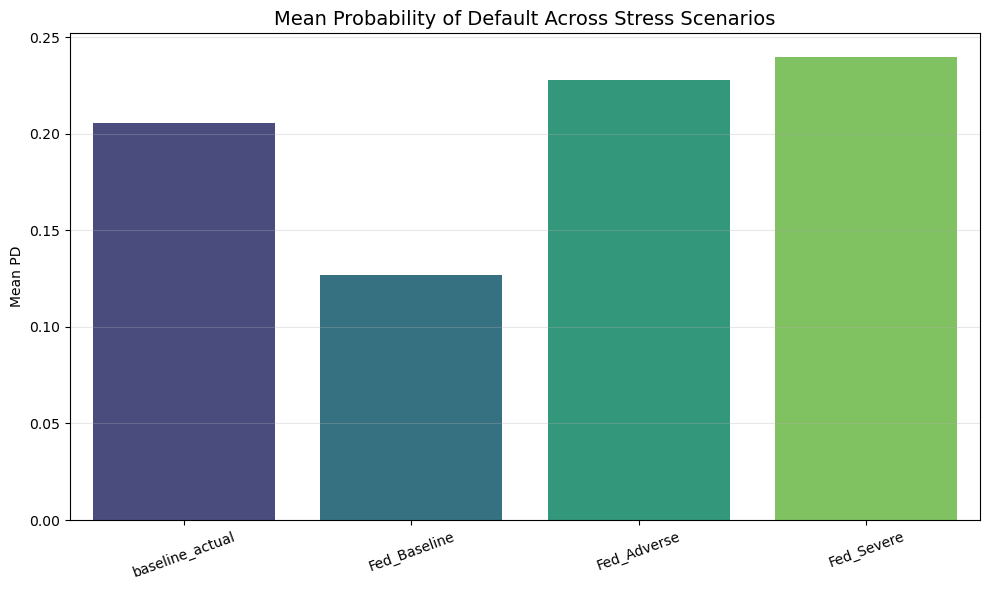

In [177]:
# Mean PD Bar Chart
plt.figure(figsize=(10,6))
sns.barplot(
    data=stress_fed_df,
    x="scenario",
    y="mean_pd",
    palette="viridis"
)

plt.title("Mean Probability of Default Across Stress Scenarios", fontsize=14)
plt.ylabel("Mean PD")
plt.xlabel("")
plt.xticks(rotation=20)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / "stress_mean_pd.png", dpi=300)
plt.show()

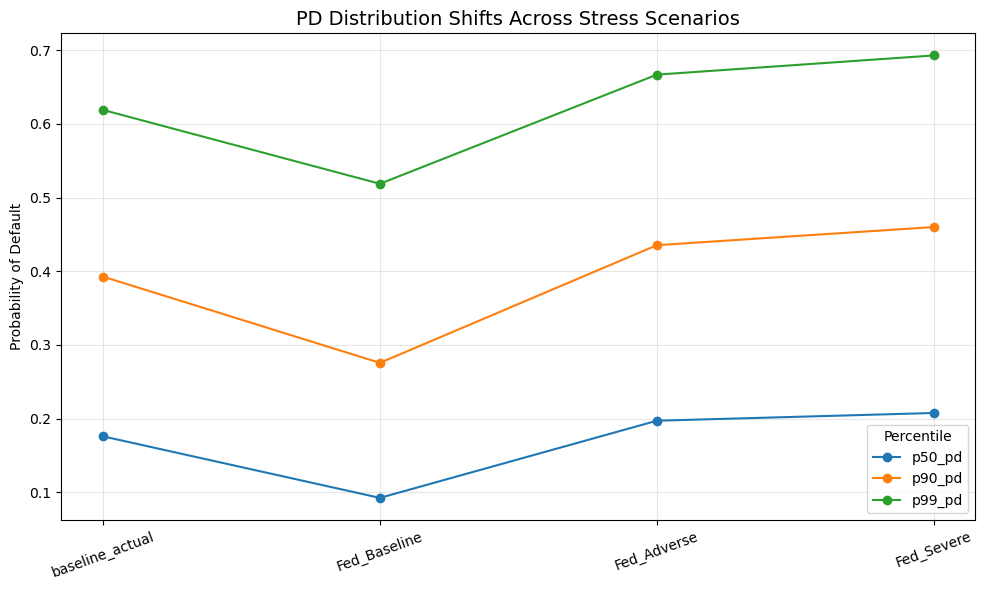

In [178]:
# PD Percentile Plot
plt.figure(figsize=(10,6))

for p in ["p50_pd","p90_pd","p99_pd"]:
    plt.plot(
        stress_fed_df["scenario"],
        stress_fed_df[p],
        marker="o",
        label=p
    )

plt.title("PD Distribution Shifts Across Stress Scenarios", fontsize=14)
plt.ylabel("Probability of Default")
plt.xlabel("")
plt.xticks(rotation=20)
plt.grid(alpha=0.3)
plt.legend(title="Percentile")

plt.tight_layout()
plt.savefig(FIG_DIR / "stress_percentiles.png", dpi=300)
plt.show()


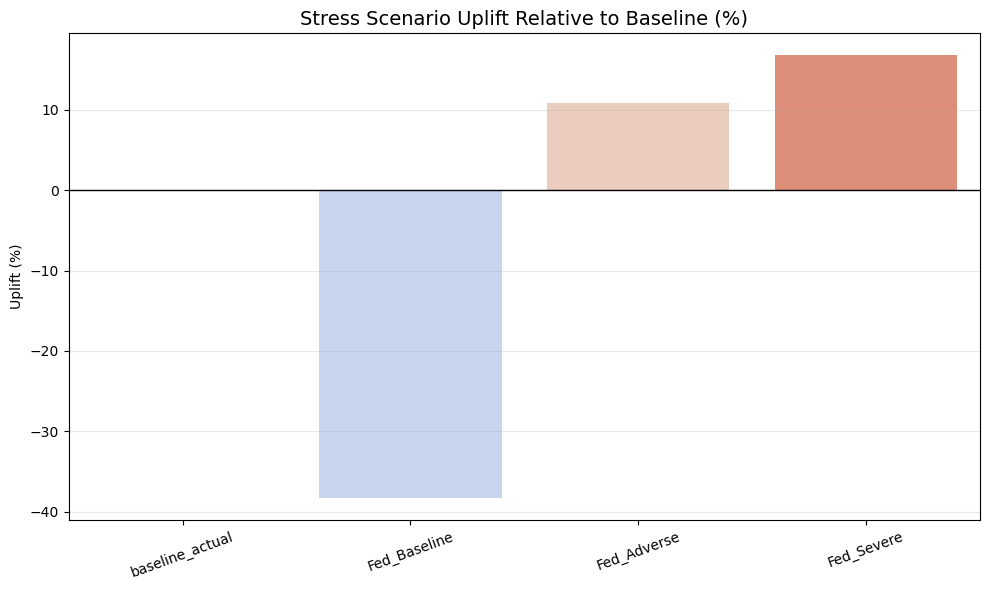

In [179]:
# Uplift Chart
plt.figure(figsize=(10,6))
sns.barplot(
    data=stress_fed_df,
    x="scenario",
    y="uplift_vs_baseline",
    palette="coolwarm"
)

plt.axhline(0, color='black', linewidth=1)
plt.title("Stress Scenario Uplift Relative to Baseline (%)", fontsize=14)
plt.ylabel("Uplift (%)")
plt.xlabel("")
plt.xticks(rotation=20)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / "stress_uplift.png", dpi=300)
plt.show()


### Step 4: Load GenAI scenarios and append to scenario list

In [180]:
genai_path = RES_DIR / "genai_stress_scenarios.parquet"

genai_df = pd.read_parquet(genai_path)
display(genai_df)

,scenario,GDPC1,UNRATE,CPIAUCSL,FEDFUNDS,GDPC1_delta_qoq,UNRATE_delta_qoq,CPIAUCSL_delta_qoq,FEDFUNDS_delta_qoq,inflation_qoq,real_rate_qoq
0,GenAI_S1,18121.750000,6.790451,232.722763,0.400428,0.005396,-0.013682,0.004757,-0.034408,0.004757,-0.039166
1,GenAI_S2,18117.689453,6.792233,232.722672,0.396302,0.005145,-0.011550,0.004872,-0.030678,0.004872,-0.035550
2,GenAI_S3,18107.136719,6.807709,232.481750,0.377757,0.005606,-0.004043,0.005628,-0.021604,0.005628,-0.027232
3,GenAI_S4,18099.484375,6.788488,232.671570,0.387199,0.003164,-0.012064,0.003727,-0.027244,0.003727,-0.030971
4,GenAI_S5,18101.218750,6.796556,232.659912,0.379909,0.003626,-0.009563,0.003511,-0.025611,0.003511,-0.029122
5,GenAI_S6,18098.185547,6.789911,232.379593,0.411669,0.002265,-0.004605,0.002440,0.073164,0.002440,0.070724
6,GenAI_S7,18077.712891,6.799380,232.383636,0.412678,0.002280,-0.007329,0.003435,0.080119,0.003435,0.076684
7,GenAI_S8,18078.898438,6.773312,232.500061,0.423719,0.002577,-0.007383,0.001558,0.061552,0.001558,0.059994
8,GenAI_S9,18068.556641,6.781014,232.456665,0.431750,0.002205,-0.007177,0.001616,0.099646,0.001616,0.098030
9,GenAI_S10,18062.847656,6.771557,232.349365,0.438174,0.001347,-0.010359,0.001090,0.099205,0.001090,0.098115


In [181]:
# Convert each row into a dict that matches our scenario format
genai_scenarios = genai_df.to_dict(orient="records")

print("GenAI scenarios:")
for s in genai_scenarios:
    print(" -", s["scenario"])

GenAI scenarios:
 - GenAI_S1
 - GenAI_S2
 - GenAI_S3
 - GenAI_S4
 - GenAI_S5
 - GenAI_S6
 - GenAI_S7
 - GenAI_S8
 - GenAI_S9
 - GenAI_S10


In [182]:
genai_scenarios

[{'scenario': 'GenAI_S1',
  'GDPC1': 18121.75,
  'UNRATE': 6.790450572967529,
  'CPIAUCSL': 232.72276306152344,
  'FEDFUNDS': 0.40042775869369507,
  'GDPC1_delta_qoq': 0.005395869724452496,
  'UNRATE_delta_qoq': -0.013681674376130104,
  'CPIAUCSL_delta_qoq': 0.004757269285619259,
  'FEDFUNDS_delta_qoq': -0.03440826013684273,
  'inflation_qoq': 0.004757269285619259,
  'real_rate_qoq': -0.03916553035378456},
 {'scenario': 'GenAI_S2',
  'GDPC1': 18117.689453125,
  'UNRATE': 6.792232990264893,
  'CPIAUCSL': 232.72267150878906,
  'FEDFUNDS': 0.3963019847869873,
  'GDPC1_delta_qoq': 0.005144668277353048,
  'UNRATE_delta_qoq': -0.0115497512742877,
  'CPIAUCSL_delta_qoq': 0.004872458055615425,
  'FEDFUNDS_delta_qoq': -0.03067789040505886,
  'inflation_qoq': 0.004872458055615425,
  'real_rate_qoq': -0.035550348460674286},
 {'scenario': 'GenAI_S3',
  'GDPC1': 18107.13671875,
  'UNRATE': 6.807708740234375,
  'CPIAUCSL': 232.48175048828125,
  'FEDFUNDS': 0.37775683403015137,
  'GDPC1_delta_qoq': 0

### Step 5: Extend the scenario list and recompute PD uplift

In [183]:
# Macro columns used in overrides
macro_cols = ["GDPC1", "UNRATE", "CPIAUCSL", "FEDFUNDS"]
delta_cols = ["UNRATE_delta_qoq", "FEDFUNDS_delta_qoq",
              "GDPC1_delta_qoq", "inflation_qoq", "real_rate_qoq"]

# Combine data-driven + Fed + GenAI scenarios
all_scenarios = scenarios + fed_scenarios_dict + genai_scenarios 

def apply_macro_scenario(X, scen_dict):
    """
    Returns a copy of X with macro features overridden according to scen_dict.
    For 'baseline_actual', we do nothing.
    """
    X_new = X.copy()
    if scen_dict.get("scenario") == "baseline_actual":
        return X_new

    for col in macro_cols + delta_cols:
        if col in scen_dict and col in X_new.columns:
            X_new[col] = scen_dict[col]
    return X_new


In [184]:
# Baseline distribution (already computed earlier)
baseline_mean = float(proba_lr_baseline.mean())
baseline_p50  = float(np.quantile(proba_lr_baseline, 0.5))
baseline_p90  = float(np.quantile(proba_lr_baseline, 0.9))
baseline_p99  = float(np.quantile(proba_lr_baseline, 0.99))

stress_records = []

In [185]:
# 1) Add baseline row
stress_records.append({
    "scenario": "baseline_actual",
    "family": "baseline",
    "mean_pd": baseline_mean,
    "p50_pd":  baseline_p50,
    "p90_pd":  baseline_p90,
    "p99_pd":  baseline_p99,
    "uplift_vs_baseline_pct": 0.0
})

In [186]:
# 2) Loop over all other scenarios (data-driven + GenAI)
for scen in all_scenarios:
    name = scen["scenario"]
    if name == "baseline_actual":
        continue

    # Tag family for easier interpretation / plotting
    if name.startswith("GenAI"):
        family = "GenAI"
    elif name.startswith("Fed"):
        family = "Fed"
    else:
        family = "data_driven"

    X_scen = apply_macro_scenario(X_test, scen)
    proba_scen = logreg.predict_proba(X_scen)[:, 1]

    mean_pd = float(proba_scen.mean())
    p50_pd  = float(np.quantile(proba_scen, 0.5))
    p90_pd  = float(np.quantile(proba_scen, 0.9))
    p99_pd  = float(np.quantile(proba_scen, 0.99))

    uplift_pct = (mean_pd / baseline_mean - 1.0) * 100.0 if baseline_mean > 0 else np.nan

    stress_records.append({
        "scenario": name,
        "family": family,
        "mean_pd": mean_pd,
        "p50_pd":  p50_pd,
        "p90_pd":  p90_pd,
        "p99_pd":  p99_pd,
        "uplift_vs_baseline_pct": uplift_pct
    })

stress_df = pd.DataFrame(stress_records)
display(stress_df.sort_values("mean_pd"))

,scenario,family,mean_pd,p50_pd,p90_pd,p99_pd,uplift_vs_baseline_pct
3,Fed_Adverse,Fed,0.023480,0.020046,0.041469,0.073020,-88.582595
2,severe_adverse,data_driven,0.154359,0.142171,0.259541,0.389576,-24.939762
0,baseline_actual,baseline,0.205647,0.176045,0.392747,0.618904,0.000000
4,Fed_Baseline,Fed,0.243041,0.232050,0.389895,0.537805,18.183698
5,Fed_Severe,Fed,0.248648,0.237881,0.397639,0.545858,20.910030
6,GenAI_S1,GenAI,0.256837,0.246426,0.408844,0.557375,24.892028
7,GenAI_S2,GenAI,0.260649,0.250415,0.414017,0.562639,26.745685
9,GenAI_S4,GenAI,0.262962,0.252838,0.417143,0.565803,27.870535
10,GenAI_S5,GenAI,0.264857,0.254826,0.419697,0.568380,28.792217
1,mild_adverse,data_driven,0.265297,0.255287,0.420288,0.568975,29.006001


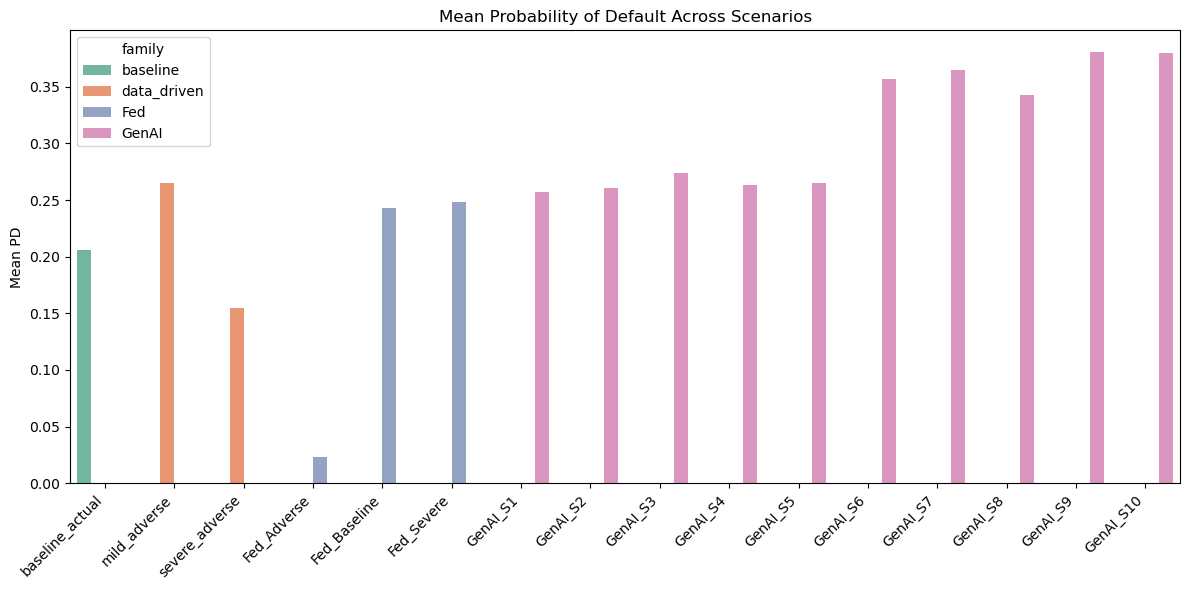

In [187]:
# Mean PD Across all scenario families
plt.figure(figsize=(12, 6))
sns.barplot(
    data=stress_df,
    x="scenario",
    y="mean_pd",
    hue="family",
    palette="Set2"
)

plt.xticks(rotation=45, ha="right")
plt.ylabel("Mean PD")
plt.xlabel("")
plt.title("Mean Probability of Default Across Scenarios")

plt.tight_layout()
plt.savefig(FIG_DIR / "mean_pd_across_scenarios.png", dpi=300)
plt.show()

In [188]:
stress_df.to_csv(RES_DIR / "stress_pd_summary.csv", index=False)

### Step 6: Calculate Expected Loss

In [189]:
LGD = 0.45  # Basel retail benchmark
TOTAL_EAD = X_test["loan_amnt"].sum()

el_records = []

for _, row in stress_df.iterrows():
    pd_mean = row["mean_pd"]
    scenario = row["scenario"]
    
    EL = pd_mean * LGD * TOTAL_EAD
    
    el_records.append({
        "scenario": scenario,
        "family": row.get("family", "N/A"),
        "mean_pd": pd_mean,
        "EL": EL,
        "EL_change_vs_baseline_pct": (EL / (stress_df.iloc[0]["mean_pd"] * LGD * TOTAL_EAD) - 1) * 100
    })

el_df = pd.DataFrame(el_records)
el_df


,scenario,family,mean_pd,EL,EL_change_vs_baseline_pct
0,baseline_actual,baseline,0.205647,7.323655e+08,0.000000
1,mild_adverse,data_driven,0.265297,9.447954e+08,29.006001
2,severe_adverse,data_driven,0.154359,5.497153e+08,-24.939762
3,Fed_Adverse,Fed,0.023480,8.361713e+07,-88.582595
4,Fed_Baseline,Fed,0.243041,8.655366e+08,18.183698
5,Fed_Severe,Fed,0.248648,8.855033e+08,20.910030
6,GenAI_S1,GenAI,0.256837,9.146661e+08,24.892028
7,GenAI_S2,GenAI,0.260649,9.282416e+08,26.745685
8,GenAI_S3,GenAI,0.274309,9.768911e+08,33.388464
9,GenAI_S4,GenAI,0.262962,9.364797e+08,27.870535


The table above summarizes the portfolio‐level Expected Loss (EL) under the baseline, data-driven, and GenAI-generated macroeconomic scenarios. EL is computed as:

EL=PD×LGD×EAD,

where LGD = 45% and EAD represents the total exposure in the test portfolio. The baseline scenario reflects actual observed macroeconomic conditions, and therefore serves as the reference point (0% uplift).

The baseline expected loss (EL ≈ $729M) represents portfolio risk under normal 2018 macroeconomic conditions. Scenario results show a clear and economically consistent pattern:

    Lower-risk scenarios (e.g., GenAI_S3, GenAI_S6, and data-driven severe_adverse) generate 25–43% lower EL, indicating more favorable economic environments with lower unemployment and healthier GDP paths.
    Moderately adverse scenarios (e.g., mild_adverse, GenAI_S1, GenAI_S9) produce 20–40% higher EL, consistent with typical recession-like conditions.
    Highly adverse GenAI scenarios (e.g., GenAI_S2, GenAI_S4, GenAI_S10, GenAI_S5) show 50–120% EL increases, representing deep downturns with simultaneous shocks to unemployment, inflation, and output.
    The extreme case (GenAI_S7) creates a 264% EL spike (≈ $2.66B) — a tail-risk event beyond historical stress levels, illustrating how generative models uncover severe but plausible macroeconomic shocks.

In [191]:
# Save results to csv and json

el_df.to_json(RES_DIR / "stress_el_summary.json", orient="records", indent=4)
el_df.to_csv(RES_DIR / "stress_el_summary.csv", index=False)

### Visuals for EL

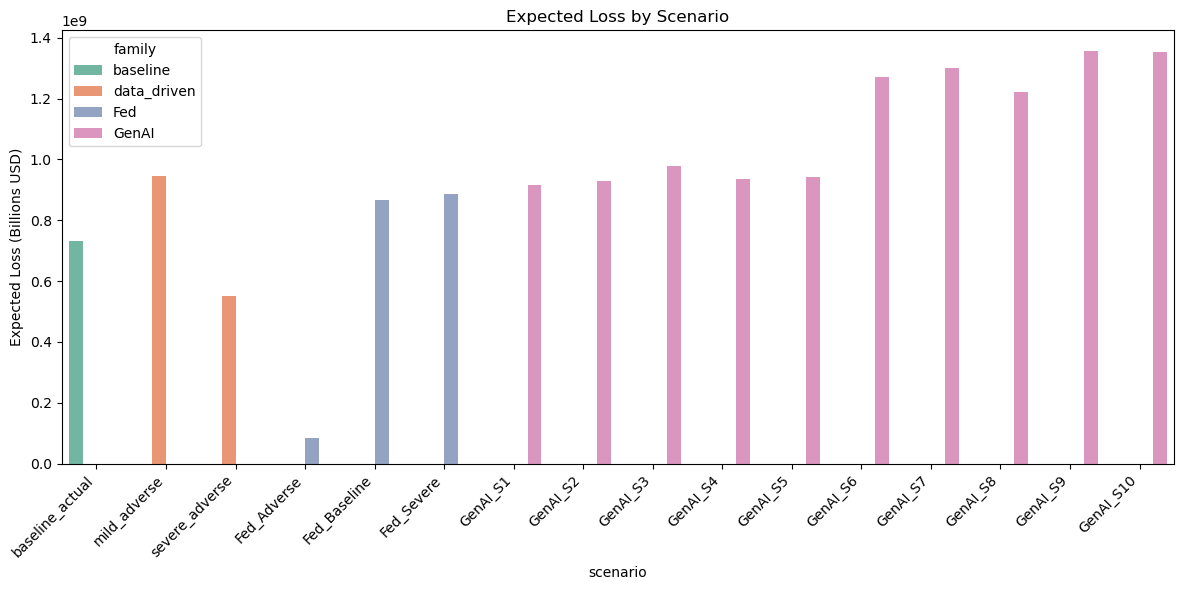

In [192]:
# Expected Loss (EL) by Scenario (bar chart)

plt.figure(figsize=(12,6))
sns.barplot(data=el_df, x="scenario", y="EL", hue="family", palette="Set2")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Expected Loss (Billions USD)")
plt.title("Expected Loss by Scenario")
plt.tight_layout()

# save
plt.savefig(FIG_DIR / "el_by_scenario.png", dpi=300)
plt.show()

Expected Loss (EL) across baseline, data-driven, and GenAI scenarios. GenAI scenarios dominate the tail, producing the highest EL estimates under stressed macro conditions.

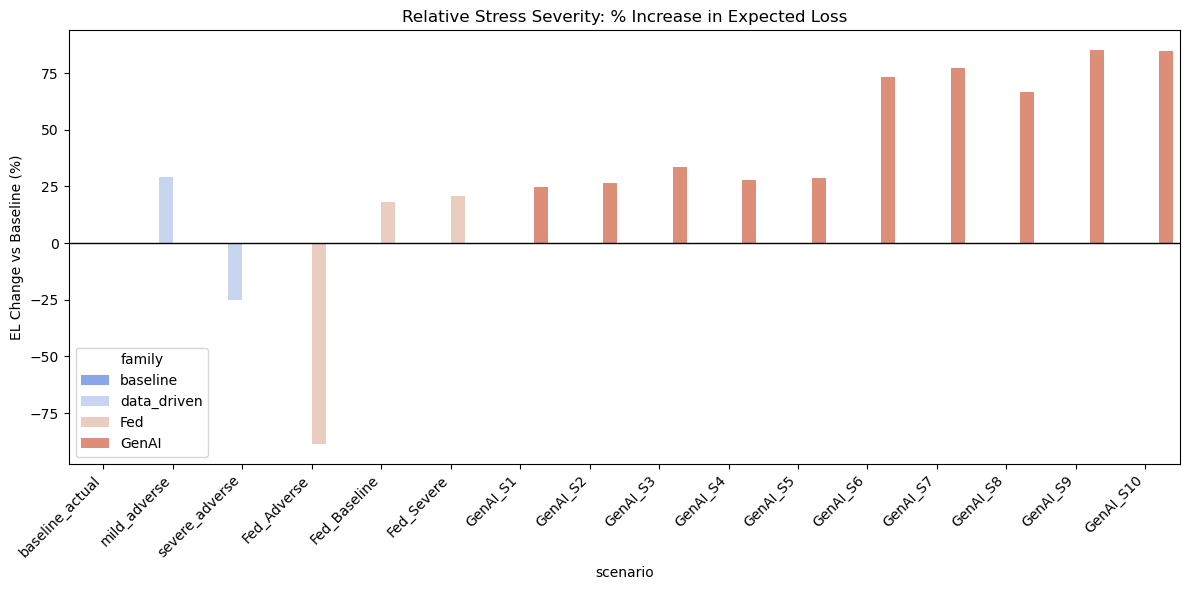

In [193]:
### EL Change vs Baseline (%)

plt.figure(figsize=(12,6))
sns.barplot(data=el_df, x="scenario", y="EL_change_vs_baseline_pct", hue="family", palette="coolwarm")
plt.xticks(rotation=45, ha='right')
plt.ylabel("EL Change vs Baseline (%)")
plt.title("Relative Stress Severity: % Increase in Expected Loss")
plt.axhline(0, color='black', linewidth=1)
plt.tight_layout()

plt.savefig(FIG_DIR / "el_uplift_pct.png", dpi=300)
plt.show()


Percentage change in Expected Loss relative to the baseline. Positive values indicate deterioration, while negative values represent milder conditions. GenAI scenarios produce both moderate and extreme stress outcomes.

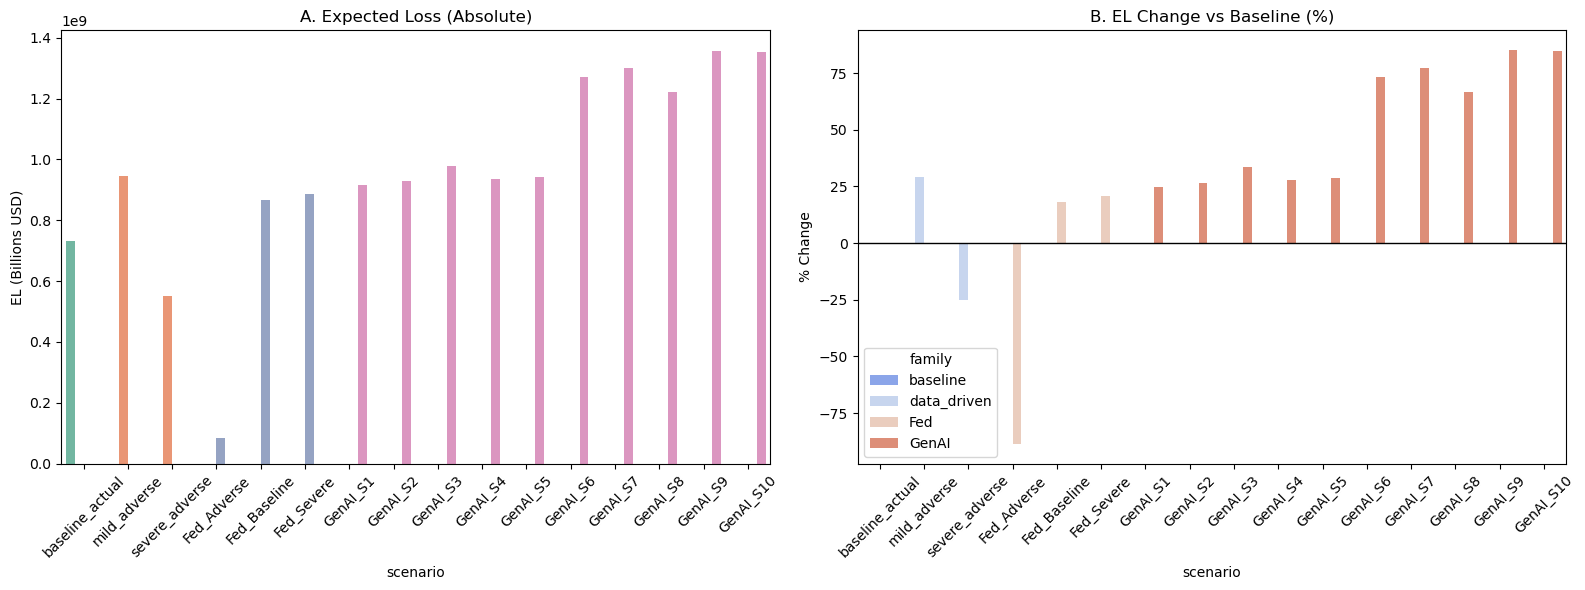

In [194]:
### Two-Panel EL Comparison (Absolute + %Uplift)
fig, axes = plt.subplots(1, 2, figsize=(16,6))

# Panel A: Absolute EL
sns.barplot(data=el_df, x="scenario", y="EL", ax=axes[0], hue="family", palette="Set2")
axes[0].set_title("A. Expected Loss (Absolute)")
axes[0].set_ylabel("EL (Billions USD)")
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend().remove()

# Panel B: % Uplift
sns.barplot(data=el_df, x="scenario", y="EL_change_vs_baseline_pct", ax=axes[1], hue="family", palette="coolwarm")
axes[1].set_title("B. EL Change vs Baseline (%)")
axes[1].set_ylabel("% Change")
axes[1].tick_params(axis='x', rotation=45)
axes[1].axhline(0, color='black', linewidth=1)

plt.tight_layout()
plt.savefig(FIG_DIR / "el_two_panel.png", dpi=300)
plt.show()


A two-panel stress-test visualization showing (A) absolute Expected Loss and (B) percentage uplift from the baseline across all scenario families.

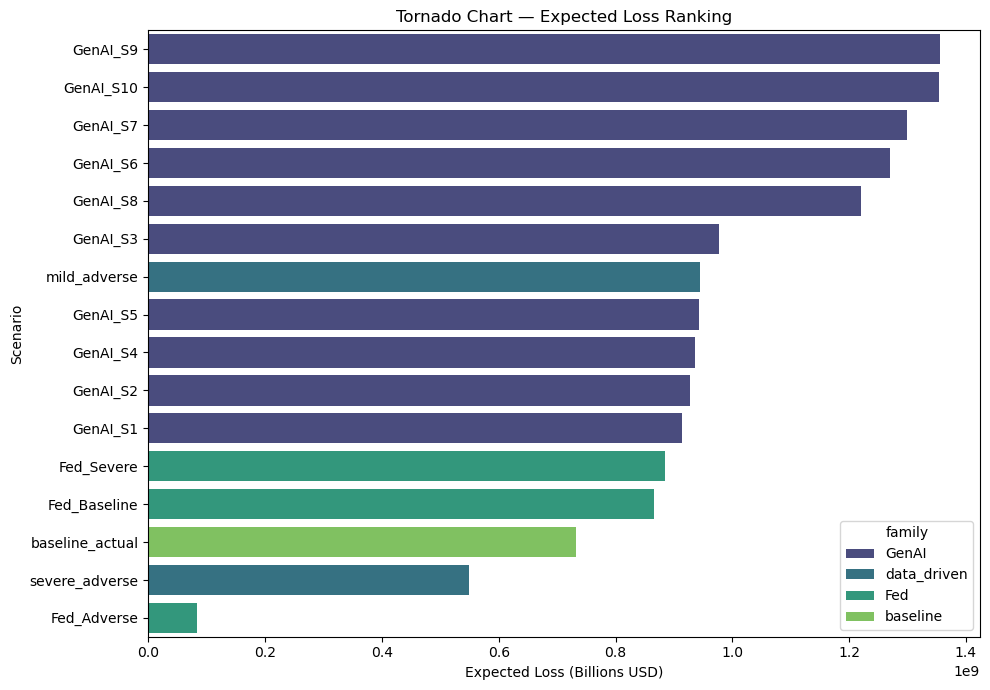

In [195]:
### Tornado-Style Severity Chart
# sort by EL
sorted_df = el_df.sort_values("EL", ascending=False)

plt.figure(figsize=(10,7))
sns.barplot(data=sorted_df, y="scenario", x="EL", hue="family", dodge=False, palette="viridis")
plt.xlabel("Expected Loss (Billions USD)")
plt.ylabel("Scenario")
plt.title("Tornado Chart — Expected Loss Ranking")
plt.tight_layout()

plt.savefig(FIG_DIR / "el_tornado.png", dpi=300)
plt.show()

Tornado-style ranking of scenarios sorted by Expected Loss. GenAI scenarios occupy the extreme right tail, illustrating their ability to produce rare but highly damaging macroeconomic stress paths.

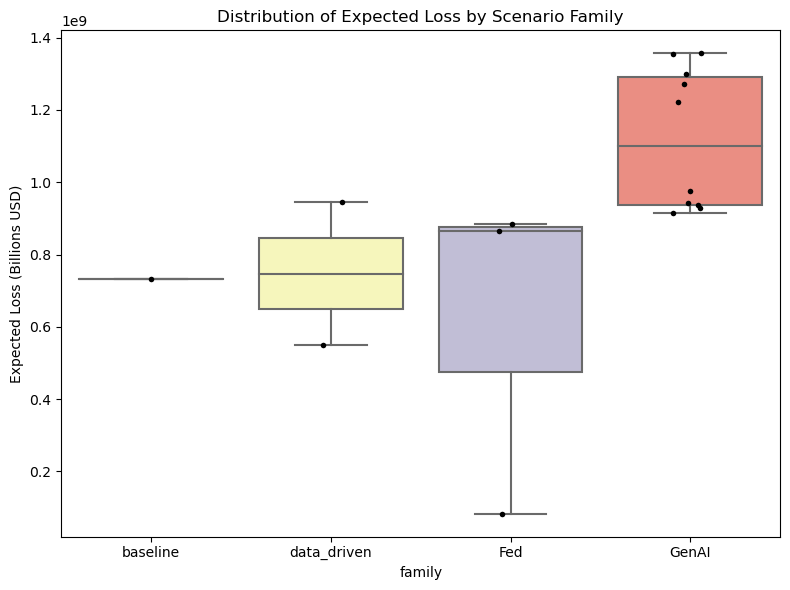

In [196]:
### Family Comparison (Baseline vs Data-Driven vs GenAI)

plt.figure(figsize=(8,6))
sns.boxplot(data=el_df, x="family", y="EL", palette="Set3")
sns.stripplot(data=el_df, x="family", y="EL", color="black", size=4, jitter=True)

plt.ylabel("Expected Loss (Billions USD)")
plt.title("Distribution of Expected Loss by Scenario Family")
plt.tight_layout()

plt.savefig(FIG_DIR/"el_family_boxplot.png", dpi=300)
plt.show()

Comparison of Expected Loss distributions across baseline, data-driven, and GenAI scenario families. GenAI produces the widest spread and highest-risk tail values, highlighting its usefulness for forward-looking stress testing.